In [1]:
import math
import numpy as np

filename = "EK95.txt"
#EKMF95 = np.loadtxt(filename, skiprows=0)

#print(EKMF95[20,:])

def QxEK95(gender,x,t,param =[]):
    return(Qx(gender,x,t,param =param))

def Qx(gender,x,t,param =[]):
    # This is our default mortality q(x,t) = exp(a+bx+cx^2+d t)
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

def QxImproUntil2050(gender,x,t,param =[]):
    # This is our default mortality q(x,t) = exp(a+bx+cx^2+d t)
    if t>2050: t=2050
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

def QxNoReduction(gender,x,t,param =[]):
    # This is our default mortality
    t = 2024
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

def QxMedieval(gender,x,t,param =[]):
    a=-9.13275
    b= 8.09432e-2
    c= -1.1018e-5
    value=math.exp(a+(b+c*x)*x)
    alpha = 7.26502413
    beta = 0.01342065
    return(max(0,min(1,alpha*value+beta)))

def ConstantBenefit(x,param=[]):
    return(1.)

def ZeroBenefit(x,param=[]):
    return(0.)

def ExpBenefit(x,param=[]):
    x0 = param[0]
    alpha = param[1]
    return((1+alpha)**(x-x0))

def DeferredBenefit(x,param=[]):
    x0 = param[0]
    if x<x0:
        return(0.)
    return(1.)

def DeferredInflationBenefit(x,param=[]):
    x0 = param[0]
    alpha = param[1]
    s=param[2]
    if(x<s): return(0.)
    return((1+alpha)**(x-x0))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class Annuity:
    def __init__(self,Qx,i=0.02,omega=110,t0 = 2024):
        self.dIrate = i
        self.nOmega = omega
        self.psymB = ConstantBenefit
        self.psymQx = Qx
        self.dV = 1. /(1+self.dIrate)
        self.nT0 = t0
        
    def CommFu(self,gender,x,symbol):
        # Allowable symbnols l, D, N, S, C, M, R
        if symbol == "l":
            l = 100000.
            px = 1.
            for i in range(x):
                t = self.nT0 + i
                qx = self.psymQx(gender,i,t) 
                px *= (1-qx)
            return(l * px)
        if symbol == "D":
            return(self.CommFu(gender,x,"l")*self.dV**x)
        if symbol == "C":
            return((self.CommFu(gender,x,"l")-self.CommFu(gender,x+1,"l"))*self.dV**(x+1))
        if symbol == "N":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"D")
            return(sum)
        if symbol == "S":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"N")
            return(sum)
        if symbol == "M":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"C")
            return(sum)
        if symbol == "R":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"M")
            return(sum)
        return("Error")
        
    def CalcPV(self,gender,x,s,param=[]):
        PV = 0
        n  = s-x
        for i in range(s-1,x-1,-1):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            px = 1. - qx
            PV = self.psymB(i,param=param) + px * self.dV * PV # a_x = 1 + p_x v a_{x+1}
        return(PV)
    
    def CalcCF(self,gender,x,s,periods = 50,param=[]):
        CF = np.zeros(periods)
        px = 1
        for i in range(x,s):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            n = i - x
            if n >= periods:
                break
            CF[n] = px  * self.psymB(i,param=param)
            px *= (1-qx)
            #print(i, px, qx)
            
        return(CF)
        

***Task***

Calculate:

Immediate Annuity ($\ddot{a}_x$), Temporary Annuity ($\ddot{a}_{x:n}$) and Deferred Annuity (${}_m|\ddot{a}_x$)for

x=30
s=65
n=m=65-30

Both via Recursion and Commutation Functions

In [3]:
aex=Annuity(QxNoReduction)

aexGT=Annuity(Qx)
aexGT2=Annuity(QxImproUntil2050)

print("Comment: we using no generational table, since this is very tricky \nwith commutation functions!")
print("------------------------------ \n \n")
x=30
s=65
n=s-x
m=s-x
gender= 0

Dx = aex.CommFu(gender,x,"D")
Nx = aex.CommFu(gender,x,"N")
Ns = aex.CommFu(gender,s,"N")

print("Dx %12.1f"%(Dx))
print("Nx %12.1f"%(Nx))
print("Ns %12.1f"%(Ns))

DxGT = aexGT.CommFu(gender,x,"D")
NxGT = aexGT.CommFu(gender,x,"N")
NsGT = aexGT.CommFu(gender,s,"N")

Comment: we using no generational table, since this is very tricky 
with commutation functions!
------------------------------ 
 

Dx      54995.8
Nx    1784707.9
Ns     410783.7


In [4]:

print("Immediate Annuity Nx/Dx\n\n")
dValKF = Nx/Dx
dValueRec= aex.CalcPV(gender,x,110,param=[s])
print("KF %10.4f  Recursion %10.4f"%(dValKF,dValueRec))
print("Difference %10.4f  Rel Error %8.4e"%(dValKF-dValueRec, (dValKF-dValueRec)/dValueRec))

print("\nNow look how this works with GT\n")

dValKF = NxGT/DxGT
dValueRec= aexGT.CalcPV(gender,x,110,param=[])
print("KF %10.4f  Recursion %10.4f"%(dValKF,dValueRec))
print("Difference %10.4f  Rel Error %8.4e"%(dValKF-dValueRec, (dValKF-dValueRec)/dValueRec))

print("\n*** ERROR due to D(x) beeing D(x,t) etc ***")
print("--> Homework: fix it")

print("What is life expectancy? a_x where people are paid in the middle pf year w/o discounted")

xEx = 0
ex=Annuity(QxNoReduction,i=0)
exGT=Annuity(Qx,i=0)

exNoGT = ex.CalcPV(gender,xEx,110,param=[s]) -0.5 
exGT = exGT.CalcPV(gender,xEx,110,param=[s]) -0.5

print("Life Expectancy for an %d year olf %.2f and %.2f"%(xEx,exNoGT,exGT))


Immediate Annuity Nx/Dx


KF    32.4517  Recursion    32.4517
Difference     0.0000  Rel Error 2.1895e-16

Now look how this works with GT

KF    36.6577  Recursion    35.0192
Difference     1.6384  Rel Error 4.6786e-02

*** ERROR due to D(x) beeing D(x,t) etc ***
--> Homework: fix it
What is life expectancy? a_x where people are paid in the middle pf year w/o discounted
Life Expectancy for an 0 year olf 82.01 and 95.54


In [5]:
x1=25
x2=60

ex1=Annuity(QxNoReduction,i=0)
exGT1=Annuity(Qx,i=0)
ex2=Annuity(QxNoReduction,i=0)
exGT2=Annuity(Qx,i=0)

exNoGT1 = x1+ex1.CalcPV(gender,x1,110,param=[s]) -0.5 
exGT1 = x1+exGT1.CalcPV(gender,x1,110,param=[s]) -0.5
exNoGT2 = x2+ex2.CalcPV(gender,x2,110,param=[s]) -0.5 
exGT2 = x2+exGT2.CalcPV(gender,x2,110,param=[s]) -0.5

print("Person 1: %.2f, %.2f"%(exNoGT1,exGT1))
print("Person 2: %.2f, %.2f"%(exNoGT2,exGT2))

Person 1: 82.16, 91.28
Person 2: 84.21, 87.18


In [6]:
print("Deferred Annuity Ns/Dx\n")

Dx = aex.CommFu(gender,x,"D")
Nx = aex.CommFu(gender,x,"N")
Ns = aex.CommFu(gender,s,"N")

dValKF = Ns/Dx
aex.psymB= DeferredBenefit
dValueRec= aex.CalcPV(gender,x,110,param=[s])

print("KF %10.4f  Recursion %10.4f"%(dValKF,dValueRec))
print("Difference %10.4f  Rel Error %8.4e"%(dValKF-dValueRec, (dValKF-dValueRec)/dValueRec))

Sal = 70000.
R = 0.6*Sal

print("\nWhat is the price for an annuity of", R)

EE = R * dValueRec
print("\n Required Single Premium",EE)
EE_per_Annum = EE / n
EE_pa_per_Sal = EE_per_Annum / Sal
print("\n EE pa %.2f"%(EE_per_Annum))
print("in Pct Sal %.2f"%(100*EE_pa_per_Sal ))

print("Employee pays 50 pct")
print("Net Salary", Sal - 0.5*EE_per_Annum)

print("W GT")

aexGT.psymB= DeferredBenefit
dValueRec= aexGT.CalcPV(gender,x,110,param=[s])


print("\nWhat is the price for an annuity of", R)

EE = R * dValueRec
print("\n Required Single Premium",EE)
EE_per_Annum = EE / n
EE_pa_per_Sal = EE_per_Annum / Sal
print("\n EE pa %.2f"%(EE_per_Annum))
print("in Pct Sal %.2f"%(100*EE_pa_per_Sal ))

print("Employee pays 50 pct")
print("Net Salary", Sal - 0.5*EE_per_Annum)


print("W GT Until 2050")

aexGT2.psymB= DeferredBenefit
dValueRec= aexGT2.CalcPV(gender,x,110,param=[s])


print("\nWhat is the price for an annuity of", R)

EE = R * dValueRec
print("\n Required Single Premium",EE)
EE_per_Annum = EE / n
EE_pa_per_Sal = EE_per_Annum / Sal
print("\n EE pa %.2f"%(EE_per_Annum))
print("in Pct Sal %.2f"%(100*EE_pa_per_Sal ))

print("Employee pays 50 pct")
print("Net Salary", Sal - 0.5*EE_per_Annum)

Deferred Annuity Ns/Dx

KF     7.4694  Recursion     7.4694
Difference     0.0000  Rel Error 7.1346e-16

What is the price for an annuity of 42000.0

 Required Single Premium 313713.29094217287

 EE pa 8963.24
in Pct Sal 12.80
Employee pays 50 pct
Net Salary 65518.38155796896
W GT

What is the price for an annuity of 42000.0

 Required Single Premium 416411.3719160814

 EE pa 11897.47
in Pct Sal 17.00
Employee pays 50 pct
Net Salary 64051.26611548455
W GT Until 2050

What is the price for an annuity of 42000.0

 Required Single Premium 368698.0602310688

 EE pa 10534.23
in Pct Sal 15.05
Employee pays 50 pct
Net Salary 64732.884853841875


Assume we have reduction in mortality and base our reserves on a table w/o mortality imporvement. How much additional interet is needed?

$\ddot{a}_x(GT, \tilde{i}) = \ddot{a}_x(PT, i)$


In [7]:
aex.psymB= DeferredBenefit
TargetValue = aex.CalcPV(gender,x,110,param=[s])
print(TargetValue)
iL = 0
iH = 1
#TARGETQX = QxNoReduction
#TARGETQX = QxImproUntil2050
TARGETQX = Qx
psymNew= Annuity(TARGETQX,i=iL)
psymNew.psymB= DeferredBenefit
dL = psymNew.CalcPV(gender,x,110,param=[s]) - TargetValue
psymNew= Annuity(TARGETQX,i=iH)
psymNew.psymB= DeferredBenefit
dH = psymNew.CalcPV(gender,x,110,param=[s]) - TargetValue
for i in range(20):
    iM = 0.5*(iL+ iH)
    psymNew= Annuity(TARGETQX,i=iM)
    psymNew.psymB= DeferredBenefit
    dM = psymNew.CalcPV(gender,x,110,param=[s]) - TargetValue
    if dM * dL > 0:
        dL = dM
        iL = iM
    else:
        dH = dM
        iH = iM
    strFormat ="%2d Iter. --> L/M/H Value %6.4f %6.4f %6.4f f(x) %6.2f %6.2f %6.2f"
    print(strFormat%(i, iL, iM, iH, dL, dM, dH))
 

print("Task: Check whether this correct?")

7.469364070051736
 0 Iter. --> L/M/H Value 0.0000 0.5000 0.5000 f(x)  19.12  -7.47  -7.47
 1 Iter. --> L/M/H Value 0.0000 0.2500 0.2500 f(x)  19.12  -7.47  -7.47
 2 Iter. --> L/M/H Value 0.0000 0.1250 0.1250 f(x)  19.12  -7.35  -7.35
 3 Iter. --> L/M/H Value 0.0000 0.0625 0.0625 f(x)  19.12  -6.00  -6.00
 4 Iter. --> L/M/H Value 0.0000 0.0312 0.0312 f(x)  19.12  -1.62  -1.62
 5 Iter. --> L/M/H Value 0.0156 0.0156 0.0312 f(x)   4.77   4.77  -1.62
 6 Iter. --> L/M/H Value 0.0234 0.0234 0.0312 f(x)   0.95   0.95  -1.62
 7 Iter. --> L/M/H Value 0.0234 0.0273 0.0273 f(x)   0.95  -0.46  -0.46
 8 Iter. --> L/M/H Value 0.0254 0.0254 0.0273 f(x)   0.21   0.21  -0.46
 9 Iter. --> L/M/H Value 0.0254 0.0264 0.0264 f(x)   0.21  -0.13  -0.13
10 Iter. --> L/M/H Value 0.0259 0.0259 0.0264 f(x)   0.04   0.04  -0.13
11 Iter. --> L/M/H Value 0.0259 0.0261 0.0261 f(x)   0.04  -0.05  -0.05
12 Iter. --> L/M/H Value 0.0259 0.0260 0.0260 f(x)   0.04  -0.01  -0.01
13 Iter. --> L/M/H Value 0.0259 0.0259 0.0260 

In [8]:
print("Temp Annuity (Nx-Ns)/Dx\n")

dValKF = (Nx-Ns)/Dx
aex.psymB= ConstantBenefit
dValueRec= aex.CalcPV(gender,x,s,param=[s])

print("KF %10.4f  Recursion %10.4f"%(dValKF,dValueRec))
print("Difference %10.4f  Rel Error %8.4e"%(dValKF-dValueRec, (dValKF-dValueRec)/dValueRec))


def QxNo(gender,x,t,param =[]):
    return(0.)

aeT_m_i = Annuity(Qx)
aeT_nm_i = Annuity(QxNo)
aeT_m_ni = Annuity(Qx,i=0)
aeT_nm_ni = Annuity(QxNo,i=0)

allPoss = [aeT_m_i,aeT_nm_i,aeT_m_ni,aeT_nm_ni]

for i in allPoss:
    dValueRec= i.CalcPV(gender,x,s,param=[s])
    print("Recursion %10.4f"%(dValueRec))



Temp Annuity (Nx-Ns)/Dx

KF    24.9823  Recursion    24.9823
Difference     0.0000  Rel Error 0.0000e+00
Recursion    25.1047
Recursion    25.4986
Recursion    34.3504
Recursion    35.0000


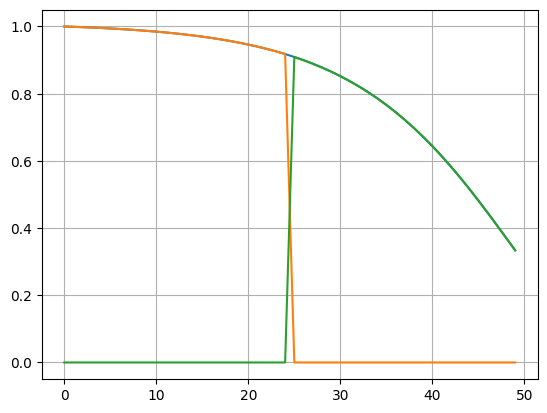

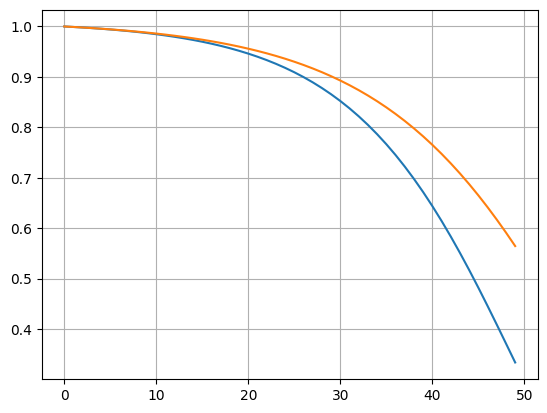

In [9]:
aex=Annuity(QxNoReduction)
aexGT=Annuity(Qx)
aext=Annuity(QxNoReduction)
aexd=Annuity(QxNoReduction)
aexd.psymB= DeferredBenefit

gender = 0
x= 40
s= 65
omega = 110

CFaex = aex.CalcCF(gender,x,omega,periods = 50,param=[])
CFaexGT = aexGT.CalcCF(gender,x,omega,periods = 50,param=[])
CFaext = aext.CalcCF(gender,x,s,periods = 50,param=[s])
CFaexd = aexd.CalcCF(gender,x,omega,periods = 50,param=[s])

plt.figure(1)
plt.plot(range(len(CFaex)), CFaex,range(len(CFaext)), CFaext,range(len(CFaexd)), CFaexd)
plt.grid(True)

plt.figure(2)
plt.plot(range(len(CFaex)), CFaex,range(len(CFaexGT)), CFaexGT)
plt.grid(True)




In [10]:
print("Immediate Annuity increasing 2% pa  (Nx-Ns)/Dx\n")

aexNewI=Annuity(QxNoReduction, i=0.)

DxNewI = aexNewI.CommFu(gender,x,"D")
NxNewI = aexNewI.CommFu(gender,x,"N")
NsNewI = aexNewI.CommFu(gender,s,"N")

aex.psymB = ExpBenefit

print("Immediate Annuity Nx/Dx\n\n")
dValKF = NxNewI/DxNewI
dValueRec= aex.CalcPV(gender,x,110,param=[x,0.02])
print("KF %10.4f  Recursion %10.4f"%(dValKF,dValueRec))
print("Difference %10.4f  Rel Error %8.4e"%(dValKF-dValueRec, (dValKF-dValueRec)/dValueRec))


Immediate Annuity increasing 2% pa  (Nx-Ns)/Dx

Immediate Annuity Nx/Dx


KF    43.0260  Recursion    43.0260
Difference     0.0000  Rel Error 1.6514e-16


How does inflation impact the price of a deferred annuity

inflation rates = 0 - 5 pct in 0.5% increases

Want to see the annual approx premium in Sal

Deferred Annuity Ns/Dx

Inflation 0.00, in Pct Sal 15.70
Inflation 0.50, in Pct Sal 18.76
Inflation 1.00, in Pct Sal 22.42
Inflation 1.50, in Pct Sal 26.81
Inflation 2.00, in Pct Sal 32.09
Inflation 2.50, in Pct Sal 38.44
Inflation 3.00, in Pct Sal 46.08
Inflation 3.50, in Pct Sal 55.29
Inflation 4.00, in Pct Sal 66.39
Inflation 4.50, in Pct Sal 79.79


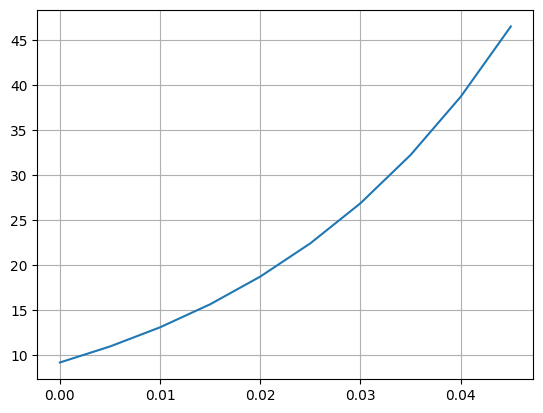

In [11]:
print("Deferred Annuity Ns/Dx\n")

InflationRates = np.arange(0.,0.05,0.005)

aex.psymB = DeferredInflationBenefit 
y=[]

for myInfl in InflationRates:
    Sal = 70000.
    R = 0.6*Sal
    dValueRec = aex.CalcPV(gender,x,110,param=[x,myInfl,s])
    y.append(dValueRec)
#print("\nWhat is the price for an annuity of", R)
    EE = R * dValueRec
#print("\n Required Single Premium",EE)
    EE_per_Annum = EE / n
    EE_pa_per_Sal = EE_per_Annum / Sal
#print("\n EE pa %.2f"%(EE_per_Annum))
    print("Inflation %.2f, in Pct Sal %.2f"%(100*myInfl, 100*EE_pa_per_Sal ))

#print("Employee pays 50 pct")
#print("Net Salary", Sal - 0.5*EE_per_Annum)

plt.figure(1)
plt.plot(InflationRates,y)
plt.grid(True)

In [12]:
aex.psymB=ConstantBenefit
for i in range(60,70):
    print(i,aex.CalcPV(gender,i,110,param=[s]))
    
print("SP for 65.25?")
alpha = 0.25
EE = (1-alpha) * aex.CalcPV(gender,65,110,param=[s]) + alpha * aex.CalcPV(gender,66,110,param=[s])
print(EE)

60 19.127496600883504
61 18.610706001697725
62 18.09205385643614
63 17.57199420619813
64 17.051006127058066
65 16.52959321420765
66 16.008282834009
67 15.487625126436612
68 14.968191741832403
69 14.450574297875464
SP for 65.25?
16.399265619157987


How does the PV depend on interest rates
Calculate PV for different interest rates


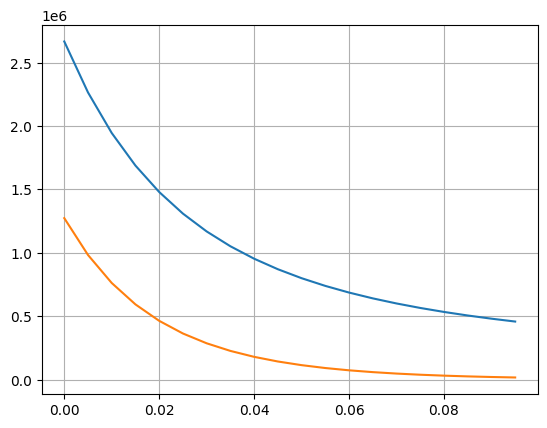

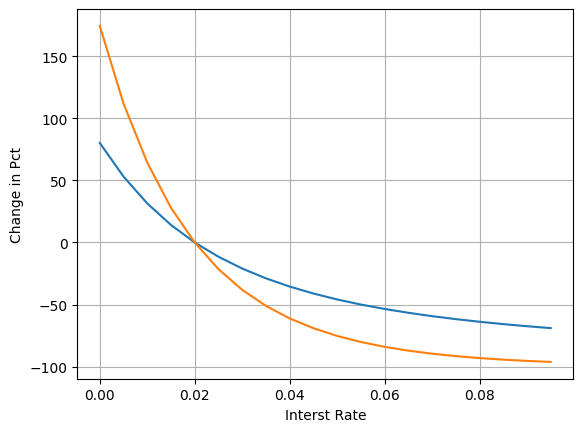

In [13]:
import numpy as np
print("How does the PV depend on interest rates")
x= 30
R = 40000
s = 65
gender = 1
print("Calculate PV for different interest rates")

InterestRates = np.arange(0.,0.10,0.005)
xI  = []
yAex = []
yAexd = []

for iRate in InterestRates:
    xI.append(iRate)
    aex = Annuity(Qx,i=iRate)
    yAex.append(aex.CalcPV(gender,x,110)*R)
    aex.psymB= DeferredBenefit
    yAexd.append(aex.CalcPV(gender,x,110,param=[s])*R)
    
plt.figure(1)
plt.plot(xI,yAex,xI,yAexd)
plt.grid(True)

yAexR = []
yAexdR = []
refIndex = 4 #ie 2%

for i in range(len(yAex)):
    yAexR.append((yAex[i]-yAex[refIndex])/yAex[refIndex]*100)
    yAexdR.append((yAexd[i]-yAexd[refIndex])/yAexd[refIndex]*100)
    
plt.figure(2)
plt.plot(xI,yAexR,xI,yAexdR)
plt.ylabel("Change in Pct")
plt.xlabel("Interst Rate")
plt.grid(True)


    
    
